In [1]:
import numpy as np
import os
import kagglehub
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [2]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00


In [3]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, ds_file, labels, transform=None):
        self.transform = transform
        data_np = np.load(ds_file)
        labels_np = np.load(labels)
        self.data = torch.from_numpy(data_np)
        self.labels = torch.from_numpy(labels_np)
        self.length = data_np.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        if self.transform:
            self.data = self.transform(self.data)

        return self.data[index], self.labels[index]

100%|██████████| 1.18G/1.18G [00:07<00:00, 162MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fmena14/crowd-counting/versions/3
tensor([38], dtype=torch.uint8)


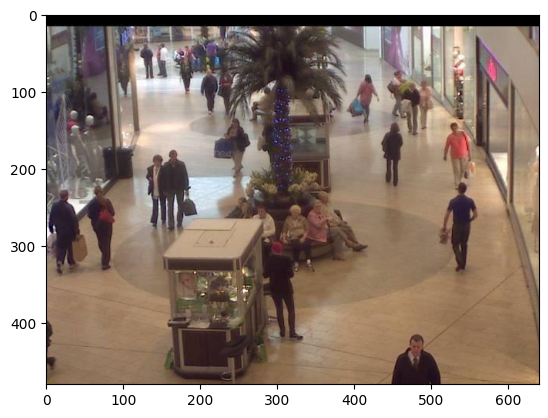

In [4]:
# Download latest version

path = kagglehub.dataset_download("fmena14/crowd-counting")

# train_data = np.load(os.path.join(path, "images.npy"))
all_data = DataSet(os.path.join(path, "images.npy"), os.path.join(path, "labels.npy"))
training_size = int(0.7 * len(all_data))
testing_size = (len(all_data)-training_size)

train_data, test_data = torch.utils.data.random_split(all_data, [training_size, testing_size])
# plt.imshow(train_data[0])
# train_data_tensor = torch.from_numpy(train_data).float()
# print(train_data_tensor.shape)
labels = np.load(os.path.join(path, "labels.npy"))


train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=8)

print("Path to dataset files:", path)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg)



# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)


# show images
imshow(images[0])
print(labels[0])

In [5]:
from ultralytics import YOLO


yolo = YOLO("yolov8s.pt")
dev = "cuda" if torch.cuda.is_available() else "cpu"
##We can compare our CNN preformance to a pretrained YOLO model
##Training our own YOLO is not possible since the dataset does not contain bounding box annotation

testing_YOLO = iter(test_loader)
#images, labels = next(dataiter)

def YOLOCount(images, conf, device=dev):
    #necessary shape for YOLO
    imgs = images.permute(0, 3, 1, 2). to(device) # convert to B C H W
    imgs = torch.nn.functional.interpolate(imgs.float(), size=(640, 640))
    imgs = imgs.float() / 255.0
    ##Count number of 'person' labels
    objects = yolo.predict(source=imgs, device=dev, conf=conf)


    people = 0
    count = 0
    for obj in objects:
        ## Exclude non-person objects
        ## CLASS ID for person is 0
        count += sum([d.cls == 0 for d in obj.boxes])

    return int(count)

correct = 0
total = 0
true_pos = 0
false_pos = 0
false_neg = 0
error, total_error = 0, 0
for image, label in test_loader:
    pred_count = YOLOCount(image, conf=0.10) #For this task YOLO seems to only preform well with shockingly low confidence intervals
    real_count = label.item()

    '''# Alternate approach for determining accuracy
    # Compare predicted results to the ground truth (from labels)
    # Accept count correct if within 20%
    if abs(pred_count - label.item()) <= 0.20 * label.item():
        correct += 1
    total += 1'''

    error = np.mean(np.abs(pred_count - label.item()))
    total_error += error
    total += 1
    ## NOT a "true" fp and tp count since the model could have both missed people
    # and identified non-existant people simultaneouly
    '''if pred_count <= real_count:
        true_pos += pred_count
        false_neg += (real_count - pred_count)
    else:
        true_pos += real_count
        false_pos += (pred_count - real_count)'''

print(f"YOLO ACCURACY (in number of people missed): {total_error / total:.2f} \n \n")









Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 640x640 22 persons, 2 suitcases, 1 couch, 4 potted plants, 129.0ms
Speed: 0.1ms preprocess, 129.0ms inference, 53.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 35 persons, 1 motorcycle, 1 train, 5 handbags, 5 suitcases, 4 potted plants, 2 dining tables, 8.6ms
Speed: 0.0ms preprocess, 8.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 30 persons, 1 train, 1 handbag, 1 tie, 2 suitcases, 2 potted plants, 8.5ms
Speed: 0.0ms preprocess, 8.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 28 persons, 1 bicycle, 2 benchs, 8 handbags, 1 suitcase, 2 potted plants, 1 dining table, 7.9ms
Speed: 0.0ms preproc